# GD_01

## 1. RESNET

### 1.1 Module

In [1]:
!pip install -U tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.3 MB 4.2 MB/s 
     |████████████████████████████████| 98 kB 9.4 MB/s 
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.utils import plot_model

import urllib3
urllib3.disable_warnings()

In [3]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 1.2 Data

In [4]:
# tfds.disable_progress_bar() # 이 주석을 풀면 데이터셋 다운로드 과정의 프로그레스바가 나타나지 않는다.

(cd_train, cd_test), cd_info = tfds.load('cats_vs_dogs', split = ('train[:80%]', 'train[80%:]'), shuffle_files = True, with_info = True, as_supervised = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteLDRQVJ/cats_vs_dogs-train.tfrecord*...:   0%|    …

Dataset cats_vs_dogs downloaded and prepared to ~/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [5]:
# Tensorflow 데이터셋을 로드한 후 꼭 feature 정보를 확인해 보자.
print(cd_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [6]:
# 데이터 갯수 확인하기
print(tf.data.experimental.cardinality(cd_train))
print(tf.data.experimental.cardinality(cd_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [7]:
# 우리의 모델에 넣어주기 전에는 각 채널별 최댓값인 255로 정규화(normalize)를 해주어 이미지의 표현이 0과 1 사이로 들어오도록 만들어준다.
def normalize_and_resize_img(image, label):
    """Normalizes images : 'uin8' -> 'float32'."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def apply_normalize_on_dataset(cd, is_test = False, batch_size = 16):
    cd = cd.map(normalize_and_resize_img, num_parallel_calls = 1)
    cd = cd.batch(batch_size)
    
    if not is_test:
        cd = cd.repeat()
        cd = cd.shuffle(200)
    
    cd = cd.prefetch(tf.data.experimental.AUTOTUNE)
    return cd

In [8]:
cd_info.features["label"].num_classes

2

In [9]:
cd_info.features["label"].names

['cat', 'dog']

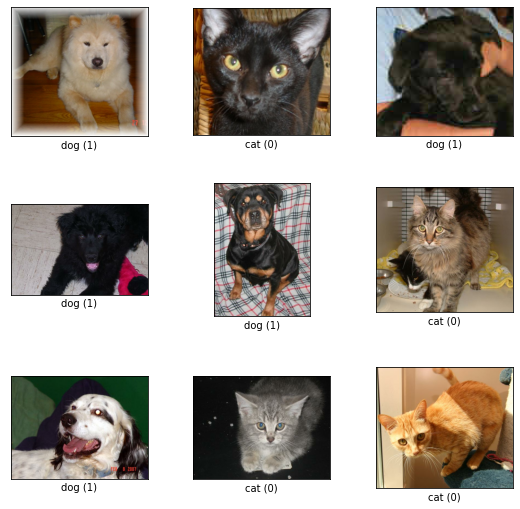

In [10]:
fig = tfds.show_examples(cd_train, cd_info)

### 1.3 ResNet34

#### 1.3.1 ResNet34 Block

In [11]:
def build_resnet_block(input_layer, 
                       num_cnn=3, 
                       channel=64, 
                       block_num=1, 
                       strides=1
                       ):
    # 입력 레이어
    # input_tensor = keras.Input(shape = input_shape, dtype = "float32", name = "input")
    x = input_layer
    # CNN 레이어
    for cnn_num in range(num_cnn):
      short_x = x
      if strides == 1:
        x = keras.layers.Conv2D(filters=channel, kernel_size=(3,3), strides=1, padding='same', use_bias=False)(x)  
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)
        x = keras.layers.Conv2D(filters=channel, kernel_size=(3,3), strides=1, padding='same', use_bias=False)(x) 
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Add()([x,short_x])
        x = keras.layers.Activation('relu')(x)
      else:
        x = keras.layers.Conv2D(filters=channel, kernel_size=(3,3), strides=strides, padding='same', use_bias=False)(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)
        x = keras.layers.Conv2D(filters=channel, kernel_size=(3,3), strides=1, padding='same', use_bias=False)(x)
        x = keras.layers.BatchNormalization()(x)
        short_x = keras.layers.Conv2D(filters=channel, kernel_size=(1,1), strides=strides, padding='same', use_bias=False)(short_x)
        short_x = keras.layers.BatchNormalization()(short_x)
        x = keras.layers.Add()([x,short_x])
        x = keras.layers.Activation('relu')(x)
        strides=1
    return x

#### 1.3.2 ResNet34 Build

In [12]:
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=2):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.

    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer

    output = keras.layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False)(output)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.MaxPool2D(pool_size=2, strides=2, padding='same')(output)
    channels = 64
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
      strides = 1 if channel == channels else 2
      output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i,
            strides=strides
        )
      channels = channel
        
    output = keras.layers.GlobalAvgPool2D()(output)
    output = keras.layers.Flatten()(output)
    output = keras.layers.Dense(num_classes, activation='sigmoid', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [13]:
resnet34 = build_resnet(input_shape=(224,224,3),
                        num_cnn_list=[3,4,6,3],
                        channel_list=[64,128,256,512],
                        num_classes=1
                        )

#### 1.3.3 Summary

In [14]:
resnet34.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9408        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

#### 1.3.4 Model Shape

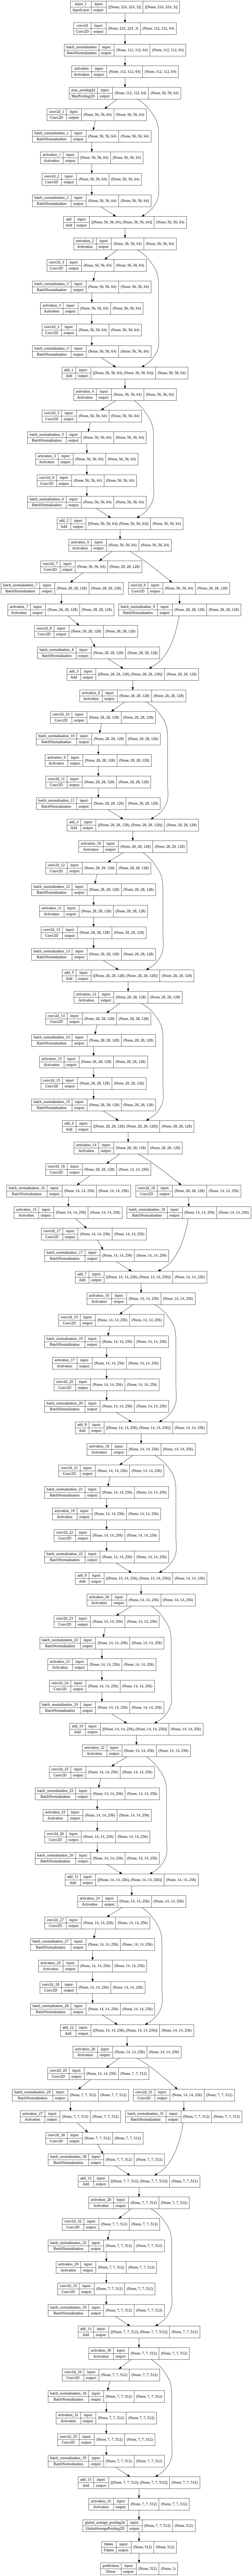

In [15]:
plot_model(resnet34, to_file='resnet34_shapes.png', show_shapes=True)

### 1.4 ResNet50

#### 1.4.1 ResNet50 Block

In [16]:
def build_resnet_block_2(input_layer, 
                        num_cnn=3, 
                        channel=64, 
                        block_num=1, 
                        strides=1
                        ):
    # 입력 레이어
    # input_tensor = keras.Input(shape = input_shape, dtype = "float32", name = "input")
    x = input_layer
    short_x = x
    short_x = keras.layers.Conv2D(filters=channel*4, kernel_size=(1,1), strides=strides, padding='same', use_bias=False)(short_x)
    short_x = keras.layers.BatchNormalization()(short_x)
 
    # CNN 레이어
    for cnn_num in range(num_cnn):
      if strides == 1:
        x = keras.layers.Conv2D(filters=channel, kernel_size=(1,1), strides=1, padding='same', use_bias=False)(x)  
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)
        x = keras.layers.Conv2D(filters=channel, kernel_size=(3,3), strides=1, padding='same', use_bias=False)(x) 
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)
        x = keras.layers.Conv2D(filters=channel*4, kernel_size=(1,1), strides=1, padding='same', use_bias=False)(x) 
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Add()([x,short_x])
        x = keras.layers.Activation('relu')(x)
        short_x = x
      else:
        x = keras.layers.Conv2D(filters=channel, kernel_size=(1,1), strides=strides, padding='same', use_bias=False)(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)
        x = keras.layers.Conv2D(filters=channel, kernel_size=(3,3), strides=1, padding='same', use_bias=False)(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)
        x = keras.layers.Conv2D(filters=channel*4, kernel_size=(1,1), strides=1, padding='same', use_bias=False)(x) 
        x = keras.layers.BatchNormalization()(x)   
        x = keras.layers.Add()([x,short_x])
        x = keras.layers.Activation('relu')(x)
        short_x = x
        strides=1
    return x

#### 1.4.2 ResNet50 Build

In [17]:
def build_resnet_2(input_shape=(32,32,3),
                  num_cnn_list=[3,4,6,3],
                  channel_list=[64,128,256,512],
                  num_classes=2):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.

    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer

    output = keras.layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False)(output)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.MaxPool2D(pool_size=2, strides=2, padding='same')(output)
    channels = 64
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
      strides = 1 if channel == channels else 2
      output = build_resnet_block_2(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i,
            strides=strides
        )
      channels = channel
        
    output = keras.layers.GlobalAvgPool2D()(output)
    output = keras.layers.Flatten()(output)
    output = keras.layers.Dense(num_classes, activation='sigmoid', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [18]:
resnet50 = build_resnet_2(input_shape=(224,224,3),
                          num_cnn_list=[3,4,6,3],
                          channel_list=[64,128,256,512],
                          num_classes=1
                         )

#### 1.4.3 Summary

In [19]:
resnet50.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 112, 112, 64  9408        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 112, 112, 64  256        ['conv2d_36[0][0]']              
 ormalization)                  )                                                           

#### 1.4.4 Model Shape

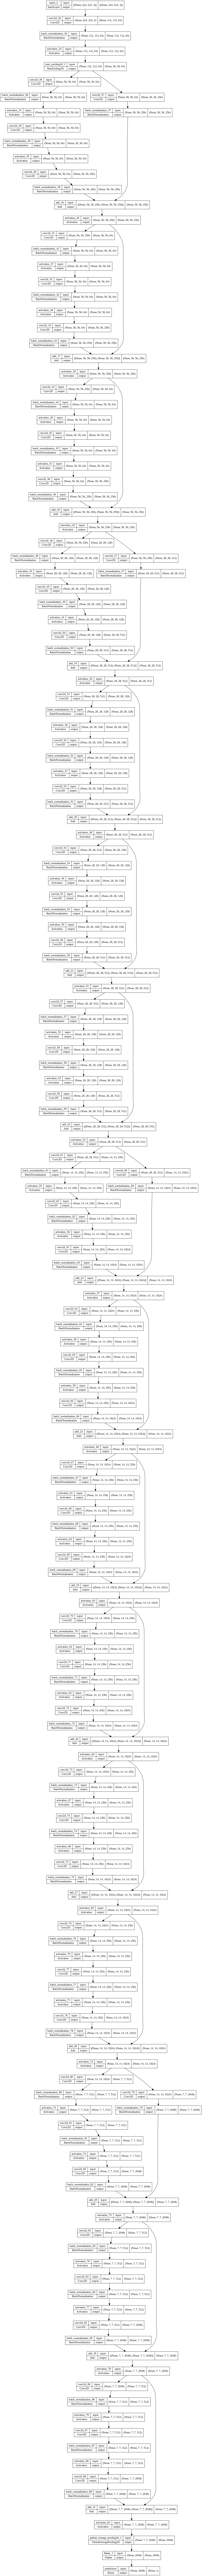

In [20]:
plot_model(resnet50, to_file='resnet50_shapes.png', show_shapes=True)

### 1.5 Plain34

#### 1.5.1 Plain34 Block

In [21]:
def build_plain_block(input_layer, 
                       num_cnn=3, 
                       channel=64, 
                       block_num=1, 
                       strides=1
                       ):
    # 입력 레이어
    # input_tensor = keras.Input(shape = input_shape, dtype = "float32", name = "input")
    x = input_layer
    # CNN 레이어
    for cnn_num in range(num_cnn):
      if strides == 1:
        x = keras.layers.Conv2D(filters=channel, kernel_size=(3,3), strides=1, padding='same', use_bias=False)(x)  
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)
        x = keras.layers.Conv2D(filters=channel, kernel_size=(3,3), strides=1, padding='same', use_bias=False)(x) 
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)
      else:
        x = keras.layers.Conv2D(filters=channel, kernel_size=(3,3), strides=strides, padding='same', use_bias=False)(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)
        x = keras.layers.Conv2D(filters=channel, kernel_size=(3,3), strides=1, padding='same', use_bias=False)(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)
        strides=1
    return x

#### 1.5.2 Plain34 Build

In [22]:
def build_plain(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=2):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.

    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer

    output = keras.layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False)(output)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.MaxPool2D(pool_size=2, strides=2, padding='same')(output)
    channels = 64
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
      strides = 1 if channel == channels else 2
      output = build_plain_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i,
            strides=strides
        )
      channels = channel
        
    output = keras.layers.GlobalAvgPool2D()(output)
    output = keras.layers.Flatten()(output)
    output = keras.layers.Dense(num_classes, activation='sigmoid', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [23]:
plain34 = build_plain(input_shape=(224,224,3),
                      num_cnn_list=[3,4,6,3],
                      channel_list=[64,128,256,512],
                      num_classes=1
                     )

#### 1.5.3 Summary

In [24]:
plain34.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_89 (Conv2D)          (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization_89 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 activation_82 (Activation)  (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_90 (Conv2D)          (None, 56, 56, 64)        3686

#### 1.5.4 Model Shape

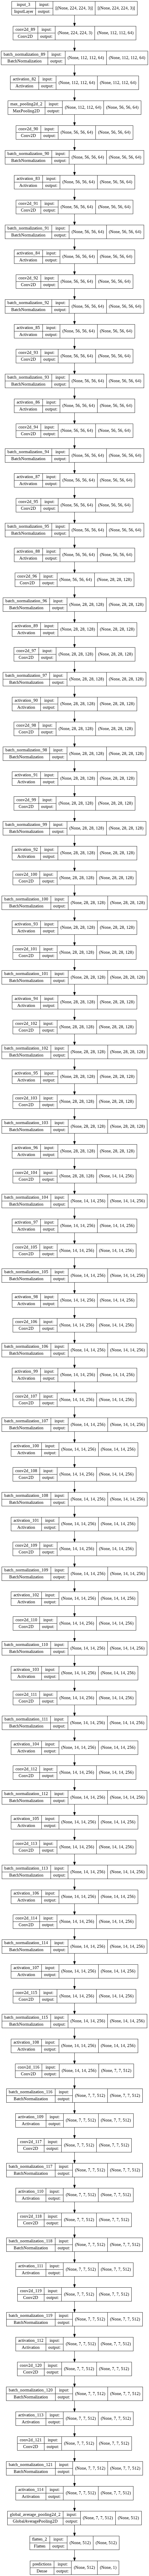

In [25]:
plot_model(plain34, to_file='resnet50_shapes.png', show_shapes=True)

### 1.6 Plain50

#### 1.6.1 Plain50 Block

In [26]:
def build_plain_block_2(input_layer, 
                        num_cnn=3, 
                        channel=64, 
                        block_num=1, 
                        strides=1
                        ):
    # 입력 레이어
    # input_tensor = keras.Input(shape = input_shape, dtype = "float32", name = "input")
    x = input_layer
    # CNN 레이어
    for cnn_num in range(num_cnn):
      if strides == 1:
        x = keras.layers.Conv2D(filters=channel, kernel_size=(1,1), strides=1, padding='same', use_bias=False)(x)  
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)
        x = keras.layers.Conv2D(filters=channel, kernel_size=(3,3), strides=1, padding='same', use_bias=False)(x) 
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)
        x = keras.layers.Conv2D(filters=channel*4, kernel_size=(1,1), strides=1, padding='same', use_bias=False)(x) 
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)
      else:
        x = keras.layers.Conv2D(filters=channel, kernel_size=(1,1), strides=strides, padding='same', use_bias=False)(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)
        x = keras.layers.Conv2D(filters=channel, kernel_size=(3,3), strides=1, padding='same', use_bias=False)(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)
        x = keras.layers.Conv2D(filters=channel*4, kernel_size=(1,1), strides=1, padding='same', use_bias=False)(x) 
        x = keras.layers.BatchNormalization()(x)   
        x = keras.layers.Activation('relu')(x)
        strides=1
    return x

#### 1.6.2 Plain50 Build

In [27]:
def build_plain_2(input_shape=(32,32,3),
                  num_cnn_list=[3,4,6,3],
                  channel_list=[64,128,256,512],
                  num_classes=2):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.

    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer

    output = keras.layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False)(output)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.MaxPool2D(pool_size=2, strides=2, padding='same')(output)
    channels = 64
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
      strides = 1 if channel == channels else 2
      output = build_plain_block_2(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i,
            strides=strides
        )
      channels = channel
        
    output = keras.layers.GlobalAvgPool2D()(output)
    output = keras.layers.Flatten()(output)
    output = keras.layers.Dense(num_classes, activation='sigmoid', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [28]:
plain50 = build_plain_2(input_shape=(224,224,3),
                        num_cnn_list=[3,4,6,3],
                        channel_list=[64,128,256,512],
                        num_classes=1
                        )

#### 1.6.3 Summary

In [29]:
plain50.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_122 (Conv2D)         (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization_122 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_115 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_123 (Conv2D)         (None, 56, 56, 64)        4096

#### 1.6.4 Model Shape

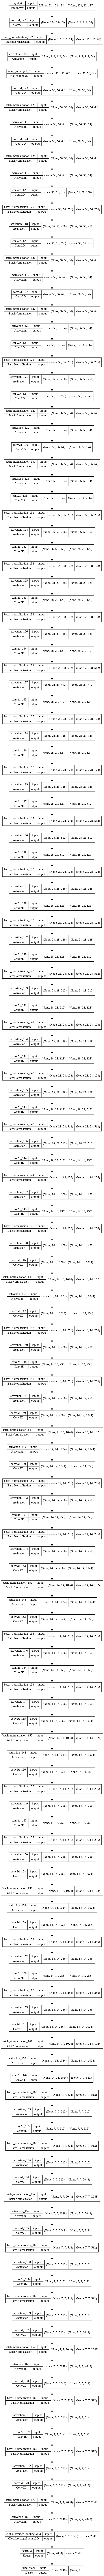

In [30]:
plot_model(plain50, to_file='resnet50_shapes.png', show_shapes=True)

# 비교

In [31]:
BATCH_SIZE = 64
EPOCH      = 50

In [32]:
(ds_train, ds_test), ds_info = tfds.load('cats_vs_dogs', 
                                         split = ('train[:80%]', 'train[80%:]'), 
                                         as_supervised = True, 
                                         shuffle_files = True,
                                         with_info = True)

ds_train = apply_normalize_on_dataset(ds_train, batch_size = BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size = BATCH_SIZE)

In [33]:
resnet34.compile(loss = "binary_crossentropy",
                  optimizer = tf.keras.optimizers.Nadam(lr = 0.0001, clipnorm = 1.),
                  metrics = ["accuracy"])

history_resnet34 = resnet34.fit(ds_train,
                                steps_per_epoch = int(ds_info.splits['train[:80%]'].num_examples / BATCH_SIZE),
                                validation_steps = int(ds_info.splits['train[80%:]'].num_examples / BATCH_SIZE),
                                epochs = EPOCH,
                                validation_data = ds_test,
                                verbose = 1,
                                use_multiprocessing = True)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


290/290 [==============================] - 111s 248ms/step - loss: 0.6047 - accuracy: 0.6749 - val_loss: 0.9686 - val_accuracy: 0.4828
Epoch 2/50
290/290 [==============================] - 68s 234ms/step - loss: 0.4583 - accuracy: 0.7822 - val_loss: 0.6545 - val_accuracy: 0.6916
Epoch 3/50
290/290 [==============================] - 68s 233ms/step - loss: 0.3421 - accuracy: 0.8515 - val_loss: 0.7898 - val_accuracy: 0.6695
Epoch 4/50
290/290 [==============================] - 68s 234ms/step - loss: 0.2329 - accuracy: 0.9060 - val_loss: 0.4397 - val_accuracy: 0.8204
Epoch 5/50
290/290 [==============================] - 68s 233ms/step - loss: 0.1500 - accuracy: 0.9395 - val_loss: 1.0270 - val_accuracy: 0.7412
Epoch 6/50
290/290 [==============================] - 68s 234ms/step - loss: 0.1069 - accuracy: 0.9586 - val_loss: 0.4734 - val_accuracy: 0.8535
Epoch 7/50
290/290 [==============================] - 68s 236ms/step - loss: 0.0791 - accuracy: 0.9712 - val_loss: 0.5310 - val_accuracy: 0.

In [34]:
plain34.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Nadam(lr = 0.0001, clipnorm = 1.),
                metrics = ["accuracy"])

history_plain34 = plain34.fit(ds_train,
                              steps_per_epoch = int(ds_info.splits['train[:80%]'].num_examples / BATCH_SIZE),
                              validation_steps = int(ds_info.splits['train[80%:]'].num_examples / BATCH_SIZE),
                              epochs = EPOCH,
                              validation_data = ds_test,
                              verbose = 1,
                              use_multiprocessing = True)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


290/290 [==============================] - 87s 226ms/step - loss: 0.6611 - accuracy: 0.6092 - val_loss: 0.8641 - val_accuracy: 0.4883
Epoch 2/50
290/290 [==============================] - 65s 225ms/step - loss: 0.5428 - accuracy: 0.7257 - val_loss: 0.8257 - val_accuracy: 0.7376
Epoch 3/50
290/290 [==============================] - 65s 225ms/step - loss: 0.4343 - accuracy: 0.8024 - val_loss: 1.0239 - val_accuracy: 0.6696
Epoch 4/50
290/290 [==============================] - 67s 233ms/step - loss: 0.3543 - accuracy: 0.8444 - val_loss: 0.6664 - val_accuracy: 0.7280
Epoch 5/50
290/290 [==============================] - 66s 227ms/step - loss: 0.2910 - accuracy: 0.8766 - val_loss: 0.7195 - val_accuracy: 0.7515
Epoch 6/50
290/290 [==============================] - 66s 226ms/step - loss: 0.2434 - accuracy: 0.9003 - val_loss: 0.4857 - val_accuracy: 0.8147
Epoch 7/50
290/290 [==============================] - 66s 227ms/step - loss: 0.1957 - accuracy: 0.9227 - val_loss: 2.8485 - val_accuracy: 0.5

In [ ]:
resnet50.compile(loss = "binary_crossentropy",
                  optimizer = tf.keras.optimizers.Nadam(lr = 0.0001, clipnorm = 1.),
                  metrics = ["accuracy"])

history_resnet50 = resnet50.fit(ds_train,
                                steps_per_epoch = int(ds_info.splits['train[:80%]'].num_examples / BATCH_SIZE),
                                validation_steps = int(ds_info.splits['train[80%:]'].num_examples / BATCH_SIZE),
                                epochs = EPOCH,
                                validation_data = ds_test,
                                verbose = 1,
                                use_multiprocessing = True)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


290/290 [==============================] - 132s 358ms/step - loss: 0.6631 - accuracy: 0.6198 - val_loss: 1.0698 - val_accuracy: 0.4910
Epoch 2/50
290/290 [==============================] - 104s 357ms/step - loss: 0.6069 - accuracy: 0.6700 - val_loss: 1.0380 - val_accuracy: 0.5131
Epoch 3/50
290/290 [==============================] - 104s 357ms/step - loss: 0.5683 - accuracy: 0.7038 - val_loss: 1.3896 - val_accuracy: 0.5234
Epoch 4/50
290/290 [==============================] - 103s 356ms/step - loss: 0.5259 - accuracy: 0.7310 - val_loss: 0.7835 - val_accuracy: 0.6024
Epoch 5/50
290/290 [==============================] - 103s 356ms/step - loss: 0.4823 - accuracy: 0.7651 - val_loss: 0.6328 - val_accuracy: 0.6962
Epoch 6/50
290/290 [==============================] - 104s 357ms/step - loss: 0.4162 - accuracy: 0.8054 - val_loss: 0.7214 - val_accuracy: 0.6806
Epoch 7/50
290/290 [==============================] - 103s 357ms/step - loss: 0.3486 - accuracy: 0.8456 - val_loss: 0.5732 - val_accura

In [ ]:
plain50.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Nadam(lr = 0.0001, clipnorm = 1.),
                metrics = ["accuracy"])

history_plain50 = plain50.fit(ds_train,
                              steps_per_epoch = int(ds_info.splits['train[:80%]'].num_examples / BATCH_SIZE),
                              validation_steps = int(ds_info.splits['train[80%:]'].num_examples / BATCH_SIZE),
                              epochs = EPOCH,
                              validation_data = ds_test,
                              verbose = 1,
                              use_multiprocessing = True)

In [ ]:
plt.plot(history_resnet34.history['loss'], 'r')
plt.plot(history_plain34.history['loss'], 'b')
plt.title('Model train loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'plain34'], loc = 'upper left')
plt.show()

In [ ]:
plt.plot(history_resnet34.history['val_accuracy'], 'r')
plt.plot(history_plain34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'plain34'], loc = 'upper left')
plt.show()

In [ ]:
plt.plot(history_resnet50.history['loss'], 'r')
plt.plot(history_plain50.history['loss'], 'b')
plt.title('Model train loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet50', 'plain50'], loc = 'upper left')
plt.show()

In [ ]:
plt.plot(history_resnet50.history['val_accuracy'], 'r')
plt.plot(history_plain50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet50', 'plain50'], loc = 'upper left')
plt.show()